<a href="https://colab.research.google.com/github/mnhyr/ml4ds/blob/nn_fashion_mist/nn_fmnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiptos/is_notes/blob/main/nn_fmnist.ipynb)

# Introduction

This notebook presents a simple guide to creating an artificial neural network with PyTorch. It will predict the outcome of the fashion images from the [Zalando's article images](https://github.com/zalandoresearch/fashion-mnist) (Fashion-MNIST).

The guide contains the most elementary PyTorch elements to create and evaluate a network.


In [1]:
import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader # loads data in batches
from torchvision import datasets # load Fasion-MNIST
import torchvision.transforms as T # transformers for computer vision

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

# Torchvision datasets

We obtain the [Fashion-MNIST dataset](http://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) via torchvision. The dataset contains a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Note that `datasets` is an object imported from torchvision, not to confuse with from the Dataset object (used in torch.utils.data import Dataset)

```from torchvision import datasets```

When called for the first time, the datasets will be downloaded to the path specified in the `root` argument. After that, Torchvision will look first for a local copy before attempting another download.

> **torchvision.transforms**. A transformer operates on the data. Using the ' transform' argument, we can apply multiple transformations (reshape, convert to tensor, normalize, etc.) to the data obtained.

In [3]:
mytransform = T.ToTensor() # image (3D array) to Tensor

train_data = datasets.FashionMNIST(root = './', download=True, train = True, transform = mytransform)
test_data = datasets.FashionMNIST(root = './', download=True, train = False, transform = mytransform)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.2MB/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.03MB/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Note that the first image in the dataset is a 3D tensor (C, H, W) for the number of channels (C), Height (H), and Width (W).

In [31]:
img, label = train_data[0]
img.shape # returns a Tensor of Size 1,28,28

torch.Size([1, 28, 28])

We plot the first image if we reshape the image into a 2D array (HxW).

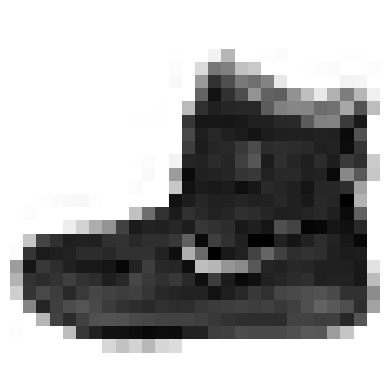

In [32]:
# We could simply plot the tensor
plt.imshow(img.reshape(28,28), cmap = 'gist_yarg'); # gist_yarg plots inverse of W&B
plt.axis('off');

# DataLoader

The PyTorch DataLoader object allows the preparation of the dataset in batches of different sizes and shuffles them if necessary when exposing them to the training.

```from torch.utils.data import DataLoader```

> Note that the DataLoader object shuffles the data by default.

In [33]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size = 100, shuffle=True)
# the test loader can be bigger and doesn't need to be shuffled
test_loader =  DataLoader(test_data,  batch_size = 500, shuffle=False)

If we run one iteration now, we will have one batch of the training dataset (100 images and labels).

In [34]:
# Plot 10 images
for img, label in train_loader:
    break # we run only one iteration , after that we break
img.shape # bz, ch, W H

torch.Size([100, 1, 28, 28])

Let's select the 50 first images of the batch to plot them.

In [35]:
myimages = img[:50].numpy() # we now obtain NumPy arrays
myimages.shape

(50, 1, 28, 28)

We will need to transpose the NumPy array to plot it with matplotlib (accepts height x width matrices).

In [37]:
myimages[0].shape # channel, height, width

(1, 28, 28)

In [38]:
myimages[0].transpose(1,2,0).shape # height, width, channel

(28, 28, 1)

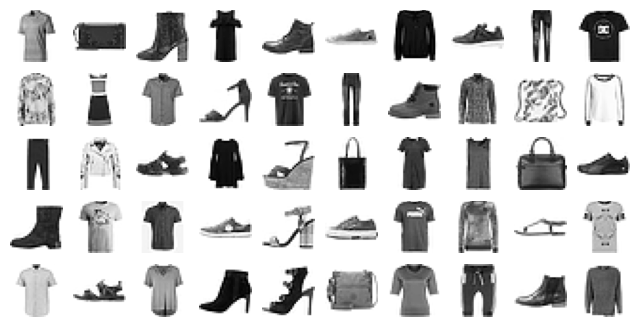

In [39]:
fig, ax = plt.subplots(nrows = 5, ncols = 10, figsize=(8,4), subplot_kw={'xticks': [], 'yticks': []})
for row in range(0,5):
    for col in range(0,10):
        myid = (10*row) + col # (ncols*rows) + cols

        ax[row,col].imshow( myimages[myid].transpose(1,2,0), cmap = 'gist_yarg' ) # W,H,C
        ax[row,col].axis('off')

# Create the network

The training set contains 60,000 records with 784 incoming features. The first layer is 784 neurons. After that, we create two fully connected layers of 120 and 84 neurons, respectively. The activation function we use is a Rectified Linear Unit (ReLU) function. This piecewise function that makes negative inputs to the neuron will be zero and scales up to positive ones.

Finally, the output layer contains ten layers. Every layer is the probability of having the label given (from 1 to 10), with the condition that the sum of the probabilities is one (Log softmax).

In [42]:
class MultilayerPerceptron(nn.Module):
    def __init__(self):
      super(MultilayerPerceptron, self).__init__()
      self.hidden1 = nn.Linear(784, 784)
      self.hidden2 = nn.Linear(784, 120)
      self.hidden3 = nn.Linear(120, 84)
      self.output = nn.LogSoftmax(dim=1)

    def forward(self, x):
      x = F.relu(self.hidden1(x))
      x = F.relu(self.hidden2(x))
      x = self.output(x)
      return x


In [43]:
torch.manual_seed(101)

mymodel = MultilayerPerceptron() # default params are in_features = 784, out_features=10
mymodel # check topology

MultilayerPerceptron(
  (hidden1): Linear(in_features=784, out_features=784, bias=True)
  (hidden2): Linear(in_features=784, out_features=120, bias=True)
  (hidden3): Linear(in_features=120, out_features=84, bias=True)
  (output): LogSoftmax(dim=1)
)

* We select the [cross-entroy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=entropy) as the cost function. The cross-entropy is similar to the quadratic formula, but it predicts the probability distribution of each class.

* We define the optimization method. The simplest one is the [Adaptative Stochastic Gradient Descent method](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

In [44]:
learning_rate = 1e-3
# imgs, labels = train_data
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(mymodel.parameters(), lr = learning_rate)

How many parameters do we need to evaluate?

* Number of weights = (784 x 120) + (120 x 84) + (84 x 10) = 105,000
* Number of biases = 120 + 84 + 10 = 214

Total = 105,214

In [45]:
params = [p.numel() for p in mymodel.parameters() if p.requires_grad]
np.sum(params)

719804

# Training and evaluation

1. Before starting, we must consider that the DataLoader returns a tensor of size [100,1,28,28], but our model accepts 1D vectors of 784 pixels (28x28). Therefore, we must flatten the tensor to accommodate the model's input.

In [46]:
# Plot 10 images
myiter = iter(train_loader)
img, label = myiter.__next__() # only one iteration
img.shape # batch_size, channel, Height, Width

torch.Size([100, 1, 28, 28])

2. We will flatten the dimensions of the batch (1,28,28) that correspond to channel, height, and width. That's a common preprocessing step when using images to allocate a 1D vector to the entry of the network (in our case, a 28 x 28 = 784 vector).

In [47]:
img.view(100,-1).shape # 100 batches of 784 pixels

torch.Size([100, 784])

Let's evaluate that batch without training the model. The prediction returns a 100 x 10 tensor. It means that we obtain ten probabilities for every batch of 100 images (shape is [100,10]).

In [48]:
y_pred = mymodel( img.view(100,-1) )
y_pred.shape # 100 x 10, meaning for every batch (100) we obtain  (10 probabilities) predictions

torch.Size([100, 120])

If we calculate the index with the highest probability for every label outcome, we obtain:

In [49]:
val, idx = torch.max(y_pred, dim=1) # dim 1 is for the output
idx # indices == predictions

tensor([51, 71, 93, 51, 93, 31, 93, 93, 51, 93, 21, 93, 51, 93, 93, 71, 93, 93,
        21, 93, 51, 51, 93, 93, 93, 51, 51, 51, 40, 93, 93, 51, 21, 51, 51, 51,
        93, 94, 31, 93, 93, 93, 93, 93, 93, 51, 93, 71, 71, 93, 66, 21, 93, 71,
        93, 93, 93, 93, 93, 51, 93, 93, 71, 93, 71, 71, 71, 51, 51, 51, 71, 93,
        51, 51, 93, 94, 51, 93, 71, 51, 51, 21, 71, 71, 51, 93, 21, 93, 71, 71,
        51, 71, 93, 71, 71, 93, 93, 51, 93, 93])

3. We will calculate the model's accuracy in every epoch (number of correct projections in/batch size) for both the train and the test dataset.

In [72]:
# tracking variables

class Loss:
    """ Class to monitor train and test lost"""
    train: list = []
    test: list = []


class Accuracy:
    """ Class to monitor train and test accuracy"""
    train: list = []
    test: list = []

In [73]:
%%time
epochs = 10

for epoch in range(epochs):
    mymodel.train()
    total_train = 0
    correct_train = 0
    total_epoch_train_loss = 0

    total_test = 0
    correct_test = 0
    total_epoch_test_loss = 0

    for batch_idx, (X_train, y_train) in enumerate(train_loader):  # Iterate over batches
        optimizer.zero_grad()
        y_pred = mymodel(X_train.view(X_train.size(0), -1))

        # Calculate loss
        loss = criterion(y_pred, y_train)
        total_epoch_train_loss += loss.item()

        # Backward pass: Compute gradient of the loss with respect to model parameters
        loss.backward()
        # Update model parameters
        optimizer.step()

        ## Calculate the number of correct predictions
        _, predicted = y_pred.max(1)  # Get the index of the highest probability class
        correct_train += (predicted == y_train).sum().item()  # Count correct predictions
        total_train += y_train.size(0)  # Total number of samples

    # Calculate training accuracy
    train_accuracy = correct_train / total_train
    Accuracy.train.append(train_accuracy)

    average_epoch_train_loss = total_epoch_train_loss / total_train
    Loss.train.append(average_epoch_train_loss)

    for batch_idx, (X_test, y_test) in enumerate(test_loader):  # Iterate over batches
        y_pred = mymodel(X_test.view(X_test.size(0), -1))

        # Calculate loss
        loss = criterion(y_pred, y_test)
        total_epoch_test_loss += loss.item()

        ## Calculate the number of correct predictions
        _, predicted = y_pred.max(1)  # Get the index of the highest probability class
        correct_test += (predicted == y_test).sum().item()  # Count correct predictions
        total_test += y_test.size(0)  # Total number of samples

    # Calculate test accuracy
    test_accuracy = correct_test / total_test
    Accuracy.test.append(test_accuracy)

    average_epoch_test_loss = total_epoch_test_loss / total_test
    Loss.test.append(average_epoch_test_loss)

CPU times: user 2min 54s, sys: 287 ms, total: 2min 54s
Wall time: 2min 55s


In [74]:
Loss.train

[0.010240127023557822,
 0.010206112796068192,
 0.010190855849782627,
 0.010224590867261091,
 0.01016307021578153,
 0.01015600344389677,
 0.010155411840478579,
 0.010106176227827867,
 0.010146489262084167,
 0.010138532630602519]

In [53]:
# Testing Phase
"""mymodel.eval()  # Set the model to evaluation mode
test_loss = 0
correct = 0
total = 0
with torch.no_grad():  # No need to track gradients for testing
    for X_test, y_test in test_loader:  # Iterate over the test set
        # Forward pass: Get predictions
        y_pred = mymodel(X_test.view(X_test.size(0), -1))
        # Calculate loss
        loss = criterion(y_pred, y_test)
        test_loss += loss.item()
        # Get the predicted class
        _, predicted = y_pred.max(1)
        total += y_test.size(0)
        correct += (predicted == y_test).sum().item()
        Loss.test.append(loss.item())"""

# Visualization

We'll see train and test losses, together with its accuracies per epoch. Note that the training data have more minor losses and reach an accuracy of almost 100%. On the other hand, the test data reach almost a plateau of > 95% accuracy, and we could think of using more than two epochs because this is where the training data crosses the accuracy of the testing data.

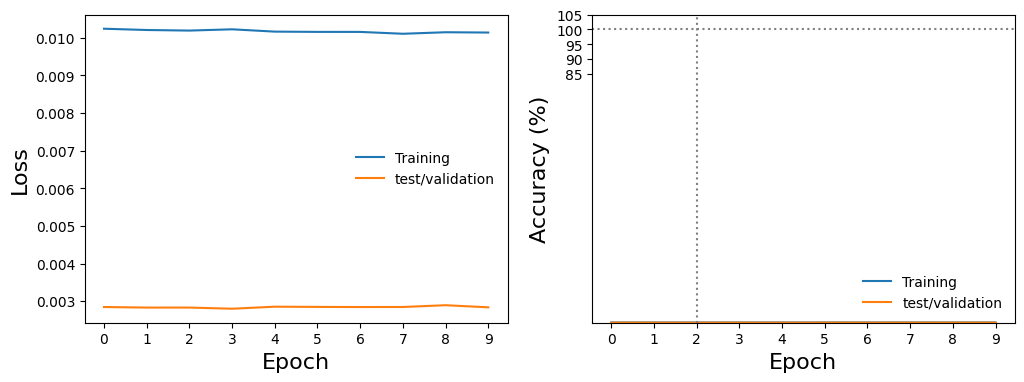

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].plot(Loss.train, label = 'Training')
ax[0].plot(Loss.test, label='test/validation')
ax[0].set_ylabel('Loss', fontsize=16)


ax[1].plot(Accuracy.train, label = 'Training')
ax[1].plot(Accuracy.test, label='test/validation')
ax[1].set_yticks(range(85,110,5))
ax[1].axvline(x=2, color='gray', linestyle=':')
ax[1].axhline(y=100, color='gray', linestyle=':')
ax[1].set_ylabel('Accuracy (%)', fontsize=16)

for myax in ax:
    myax.set_xlabel('Epoch', fontsize=16)
    myax.set_xticks(range(epochs))
    myax.legend(frameon=False)



Finally, we evaluate all the test data at once and visualize the accuracy of every outcome for every prediction (i.e., confusion matrix).

In [76]:
test_loader =  DataLoader(test_data,  batch_size = 10_000, shuffle=False) # the whole test is 10,000 images
myiter = iter(test_loader)
img, label = myiter.__next__()
img.shape

torch.Size([10000, 1, 28, 28])

In [77]:
with torch.no_grad():
    correct = 0

    for X, y_label in test_loader:
            y_val = mymodel( X.view(X.shape[0],-1) ) # flatten
            _, predicted = torch.max( y_val, dim = 1)
            correct += (predicted == y_label).sum()

print(f'Test accuracy: = {correct.item()*100/(len(test_data)):2.4f} %')

Test accuracy: = 78.2000 %


In [ ]:
# Show the confusion matrix
matrix = confusion_matrix(y_test, predictions)
matrix

In [ ]:
# Show the heatmap corresponding to the confusion matrix
plt.imshow(matrix, cmap='hot')